# Importing Libraries

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from alpha_vantage.timeseries import TimeSeries
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

import math, random
import seaborn as sns
from datetime import datetime
import datetime as dt
import yfinance as yf
import preprocessor as p

plt.style.use('ggplot')
sns.set_style('whitegrid')

%matplotlib inline


# Getting Data from yFinance  

In [13]:
def get_historical(quote):
        end = datetime.now()
        start = datetime(end.year-3,end.month,end.day)
        data = yf.download(quote, start=start, end=end)
        df = pd.DataFrame(data=data)
        df.to_csv(''+quote+'.csv')
        if(df.empty):
            ts = TimeSeries(key='N6A6QT6IBFJOPJ70',output_format='pandas')
            data, meta_data = ts.get_daily_adjusted(symbol='NSE:'+quote, outputsize='full')
            #Format df
            #Last 2 yrs rows => 502, in ascending order => ::-1
            data=data.head(503).iloc[::-1]
            data=data.reset_index()
            #Keep Required cols only
            df=pd.DataFrame()
            df['Date']=data['date']
            df['Open']=data['1. open']
            df['High']=data['2. high']
            df['Low']=data['3. low']
            df['Close']=data['4. close']
            df['Adj Close']=data['5. adjusted close']
            df['Volume']=data['6. volume']
            df.to_csv(''+quote+'.csv',index=False)
        return

In [14]:
# Company's Sticker 
quote = 'TATASTEEL.NS'
get_historical(quote)

[*********************100%***********************]  1 of 1 completed


In [15]:
df = pd.read_csv(''+quote+'.csv')
print("##############################################################################")
print("Today's",quote,"Stock Data: ")
today_stock=df.iloc[-1:]
print(today_stock)
print("##############################################################################")
df = df.dropna()
code_list=[]
for i in range(0,len(df)):
    code_list.append(quote)
df2=pd.DataFrame(code_list,columns=['Code'])
df2 = pd.concat([df2, df], axis=1)
df=df2


##############################################################################
Today's TATASTEEL.NS Stock Data: 
           Date   Open        High     Low       Close   Adj Close    Volume
748  2023-01-06  117.0  117.849998  115.25  115.650002  115.650002  58528545
##############################################################################


# Analysing Data

In [16]:
df

,Code,Date,Open,High,Low,Close,Adj Close,Volume
0,TATASTEEL.NS,2020-01-06,48.000000,48.000000,47.055000,47.325001,20.056345,96016080
1,TATASTEEL.NS,2020-01-07,47.549999,48.459999,47.355000,47.610001,20.177128,131957880
2,TATASTEEL.NS,2020-01-08,47.165001,47.814999,46.700001,47.525002,20.141106,133048410
3,TATASTEEL.NS,2020-01-09,48.500000,48.599998,47.910000,48.314999,20.475906,101311520
4,TATASTEEL.NS,2020-01-10,48.549999,49.384998,48.000000,48.619999,20.605165,159276340
...,...,...,...,...,...,...,...,...
744,TATASTEEL.NS,2023-01-02,114.400002,119.699997,113.750000,119.250000,119.250000,143444095
745,TATASTEEL.NS,2023-01-03,119.800003,120.500000,117.750000,118.449997,118.449997,74419090
746,TATASTEEL.NS,2023-01-04,118.750000,119.050003,115.349998,115.750000,115.750000,55634568
747,TATASTEEL.NS,2023-01-05,116.500000,117.000000,114.500000,116.550003,116.550003,58806907


In [6]:
df.info() # General Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749 entries, 0 to 748
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Code       749 non-null    object 
 1   Date       749 non-null    object 
 2   Open       749 non-null    float64
 3   High       749 non-null    float64
 4   Low        749 non-null    float64
 5   Close      749 non-null    float64
 6   Adj Close  749 non-null    float64
 7   Volume     749 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 46.9+ KB


In [7]:
df.describe() # Summary Stats

,Open,High,Low,Close,Adj Close,Volume
count,749.000000,749.000000,749.000000,749.000000,749.000000,7.490000e+02
mean,86.661636,88.012517,85.156856,86.535120,48.903461,1.297351e+08
std,37.482145,37.899295,36.888425,37.356999,30.957495,8.514048e+07
min,26.225000,26.795000,25.084999,25.375000,10.753930,6.744340e+06
25%,44.834999,45.424999,43.935001,44.380001,19.009560,7.200020e+07
50%,100.750000,102.000000,99.525002,100.635002,48.901093,1.094311e+08
75%,116.500000,117.864998,114.500000,116.525002,59.782818,1.656266e+08
max,151.940002,153.449997,149.175003,151.940002,119.250000,6.428460e+08


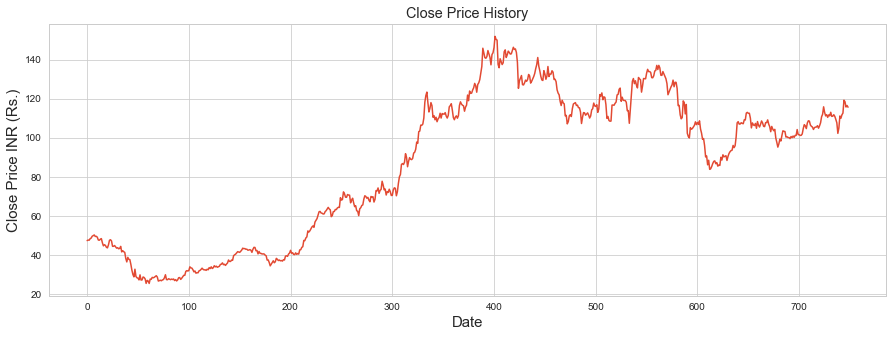

In [8]:
plt.figure(figsize=(15,5))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price INR (Rs.)', fontsize=15)
plt.show()

# Building the Model

In [28]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

In [30]:
data = df

C:\Users\Raunak\AppData\Local\Temp\ipykernel_21896\3920631822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Quantity_date['Price'] = Quantity_date['Price'].map(lambda x: float(x))


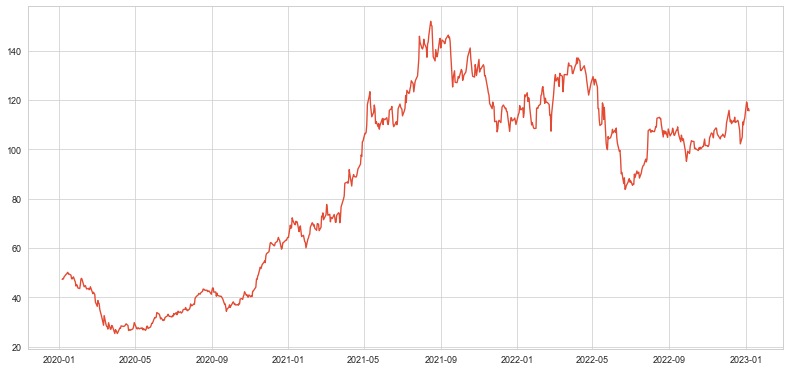

In [40]:
data['Price'] = data['Close']
Quantity_date = data[['Price','Date']]
Quantity_date.index = Quantity_date['Date'].map(lambda x: parser(x))
Quantity_date['Price'] = Quantity_date['Price'].map(lambda x: float(x))
Quantity_date = Quantity_date.fillna(Quantity_date.bfill())
Quantity_date = Quantity_date.drop(['Date'],axis =1)
fig = plt.figure(figsize=(15,7),dpi=65)
plt.plot(Quantity_date)

In [41]:
data

,Code,Date,Open,High,Low,Close,Adj Close,Volume,Price
0,TATASTEEL.NS,2020-01-06,48.000000,48.000000,47.055000,47.325001,20.056345,96016080,47.325001
1,TATASTEEL.NS,2020-01-07,47.549999,48.459999,47.355000,47.610001,20.177128,131957880,47.610001
2,TATASTEEL.NS,2020-01-08,47.165001,47.814999,46.700001,47.525002,20.141106,133048410,47.525002
3,TATASTEEL.NS,2020-01-09,48.500000,48.599998,47.910000,48.314999,20.475906,101311520,48.314999
4,TATASTEEL.NS,2020-01-10,48.549999,49.384998,48.000000,48.619999,20.605165,159276340,48.619999
...,...,...,...,...,...,...,...,...,...
744,TATASTEEL.NS,2023-01-02,114.400002,119.699997,113.750000,119.250000,119.250000,143444095,119.250000
745,TATASTEEL.NS,2023-01-03,119.800003,120.500000,117.750000,118.449997,118.449997,74419090,118.449997
746,TATASTEEL.NS,2023-01-04,118.750000,119.050003,115.349998,115.750000,115.750000,55634568,115.750000
747,TATASTEEL.NS,2023-01-05,116.500000,117.000000,114.500000,116.550003,116.550003,58806907,116.550003


In [48]:
quantity = Quantity_date.values
size = int(len(quantity) * 0.80)
train, test = quantity[0:size], quantity[size:len(quantity)]

train

array([[ 47.32500076],
       [ 47.61000061],
       [ 47.52500153],
       [ 48.31499863],
       [ 48.61999893],
       [ 49.57500076],
       [ 49.86000061],
       [ 50.20999908],
       [ 49.43999863],
       [ 49.52500153],
       [ 49.06499863],
       [ 47.61500168],
       [ 47.50500107],
       [ 48.02500153],
       [ 48.34000015],
       [ 46.24499893],
       [ 44.625     ],
       [ 45.22000122],
       [ 44.85499954],
       [ 43.86999893],
       [ 43.60499954],
       [ 45.18999863],
       [ 47.50500107],
       [ 47.75999832],
       [ 47.09999847],
       [ 44.38000107],
       [ 44.40999985],
       [ 44.79499817],
       [ 44.125     ],
       [ 43.45500183],
       [ 43.68500137],
       [ 43.13999939],
       [ 43.31999969],
       [ 44.35499954],
       [ 41.54499817],
       [ 42.13000107],
       [ 41.63000107],
       [ 41.27999878],
       [ 38.17499924],
       [ 36.40499878],
       [ 38.75500107],
       [ 37.71500015],
       [ 37.57500076],
       [ 35

In [47]:
print("Training Data Shape:",train.shape)
print("Testing Data Shape:",test.shape)

Training Data Shape: (599, 1)
Testing Data Shape: (150, 1)


In [59]:
# Using Auto ARIMA to find the best value of parameters: p,d,q

model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=12,              # frequency of series
                      max_d=10,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=1,
                      start_Q=0,
                      max_Q=10,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      n_fits = 50)
print(model_autoARIMA.summary())

C:\Users\Raunak\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2769.749, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2770.913, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2770.874, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2768.784, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2773.749, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  599
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1383.392
Date:                Sat, 07 Jan 2023   AIC                           2768.784
Time:                        01:03:49   BIC                           2773.178
Sample:                             0   HQIC                          2770.495
                                - 599                                       

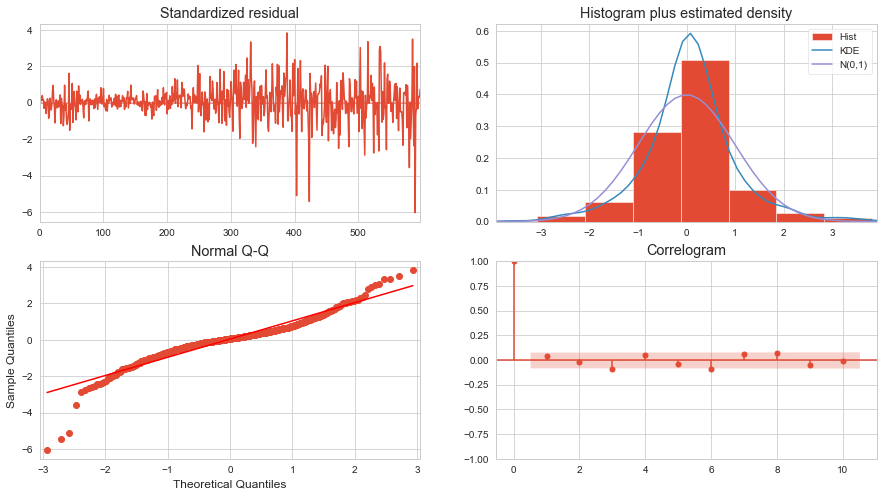

In [60]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [61]:
model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  599
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1383.392
Date:                Sat, 07 Jan 2023   AIC                           2768.784
Time:                        01:05:18   BIC                           2773.178
Sample:                             0   HQIC                          2770.495
                                - 599                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.9826      0.177     33.783      0.000       5.635       6.330
===================================================================================
Ljung-Box (L1) (Q):                   0.84   Jarque-Bera (JB):               874.40
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               9.40   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [118]:
#training the ARIMA model with the optimal value of parameters: p, d, q

history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)



In [119]:
test[1][0]

107.80999755859376


##############################################################################
Tomorrow's TATASTEEL.NS  Closing Price Prediction by ARIMA: 115.75
##############################################################################


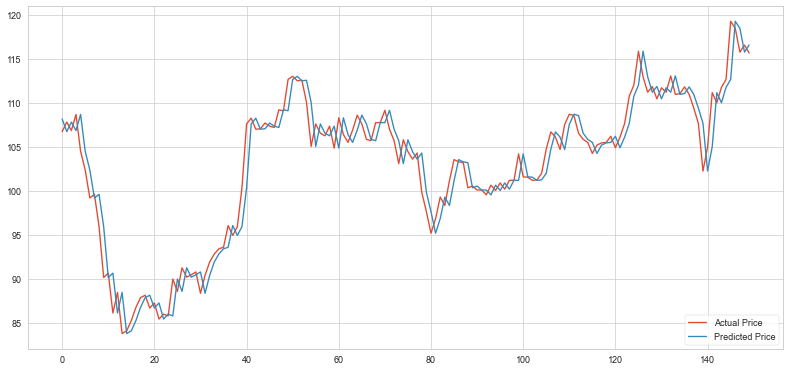

In [122]:
fig = plt.figure(figsize=(15,7),dpi=65)
plt.plot(test,label='Actual Price')
plt.plot(predictions,label='Predicted Price')
plt.legend(loc=4)
print()
print("##############################################################################")
arima_pred=predictions[-2]
print("Tomorrow's",quote," Closing Price Prediction by ARIMA:",arima_pred)
print("##############################################################################")

In [123]:
# Evaluation Metrics

from sklearn.metrics import mean_absolute_error, max_error

mae = mean_absolute_error(test, predictions)
print("MAE:", mae)

var2 = max_error(test, predictions)
print('Max Error:',var2)

rmse = math.sqrt(mean_squared_error(test, predictions))        
print("RMSE:",rmse)

mape = np.mean(np.abs(predictions - test)/np.abs(test))
print("MAPE:",np.round(mape*100,2),'%')

MAE: 1.6194340515136694
Max Error: 7.25
RMSE: 2.154887314229149
MAPE: 8.96 %
